In [ ]:
pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# SparkContext
from pyspark import SparkContext
sc = SparkContext("local", "MSML651")

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Embedding,Dot,Add,Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD 

In [ ]:
import numpy as np

In [ ]:
from pyspark.sql import SparkSession
# creat a sparksession to read data on pyspark 
spark = SparkSession.builder.getOrCreate()
df_rdd = spark.read.csv('/content/drive/MyDrive/651/ml-1m/ratings.dat',sep = '::').toDF('userId', 'movieId','rating','timestamp')
# reading data on pyspark dataframe
df_ratings = df_rdd.select('userId','movieId','rating')
df_ratings = df_ratings.withColumn("userId",df_ratings.userId.cast('int'))
df_ratings = df_ratings.withColumn("movieId",df_ratings.movieId.cast('int'))
df_ratings = df_ratings.withColumn("rating",df_ratings.rating.cast('int'))
df_ratings.limit(5).toPandas()

,userId,movieId,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [ ]:
#splitting train and test data 
train_rating, test_rating = df_ratings.randomSplit([.8,.2],seed=2021)

In [ ]:
# k value - latent factor, random k
K = 200
# mu value
mu_df = train_rating.agg({'rating': 'mean'}).collect()[0]
mu = mu_df["avg(rating)"]
# user_id and movie_id + bias(=1)
M_df = df_ratings.agg({'userId':'max'}).collect()[0]
M = M_df["max(userId)"] + 1 
N_df = df_ratings.agg({'movieId':'max'}).collect()[0]
N = N_df["max(movieId)"] + 1 
# rmse
def RMSE(y_true, y_pred):
  return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

#### Creating NN model


In [ ]:
# user and item input
user = Input(shape = (1,))
item = Input(shape = (1,))
# embedding value
P_embedding = Embedding(M,K,embeddings_regularizer = l2())(user)
Q_embedding = Embedding(N,K,embeddings_regularizer = l2())(item)
#bias
user_bias = Embedding(M, 1, embeddings_regularizer = l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer = l2())(item)

In [ ]:
R = layers.dot([P_embedding,Q_embedding],axes=(2,2))
R = layers.add([R,user_bias,item_bias])
R = Flatten()(R)
model = Model(inputs= [user,item], outputs= R)
model.compile(
    loss=RMSE,
    optimizer = SGD(),
    metrics =[RMSE]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 200)       1208200     ['input_5[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 200)       790600      ['input_6[0][0]']                
                                                                                              

In [ ]:
result = model.fit(
    x = [np.array(train_rating.select("userId").collect()).reshape(-1),
         np.array(train_rating.select("movieId").collect()).reshape(-1)],
    y = np.array(train_rating.select("rating").collect()).reshape(-1) - mu,

    epochs = 60,
    batch_size = 256,
    validation_data = (
        [np.array(test_rating.select("userId").collect()).reshape(-1),
         np.array(test_rating.select("movieId").collect()).reshape(-1)],
         np.array(test_rating.select("rating").collect()).reshape(-1) - mu
    )
)

Epoch 1/60
3128/3128 [==============================] - 60s 19ms/step - loss: 10.6608 - RMSE: 1.1140 - val_loss: 5.8922 - val_RMSE: 1.1043
Epoch 2/60
3128/3128 [==============================] - 63s 20ms/step - loss: 3.8431 - RMSE: 1.1098 - val_loss: 2.4742 - val_RMSE: 1.1014
Epoch 3/60
3128/3128 [==============================] - 62s 20ms/step - loss: 1.8925 - RMSE: 1.1077 - val_loss: 1.4963 - val_RMSE: 1.0999
Epoch 4/60
3128/3128 [==============================] - 59s 19ms/step - loss: 1.3345 - RMSE: 1.1067 - val_loss: 1.2166 - val_RMSE: 1.0992
Epoch 5/60
3128/3128 [==============================] - 58s 19ms/step - loss: 1.1748 - RMSE: 1.1061 - val_loss: 1.1365 - val_RMSE: 1.0988
Epoch 6/60
3128/3128 [==============================] - 58s 19ms/step - loss: 1.1291 - RMSE: 1.1058 - val_loss: 1.1136 - val_RMSE: 1.0986
Epoch 7/60
3128/3128 [==============================] - 58s 19ms/step - loss: 1.1160 - RMSE: 1.1055 - val_loss: 1.1071 - val_RMSE: 1.0985
Epoch 8/60
3128/3128 [===========

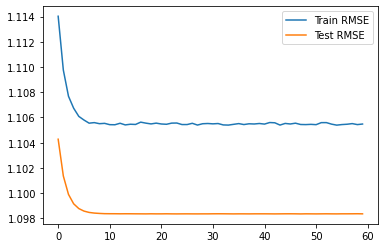

In [ ]:
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.title('MF model using Keras - RMSE')
plt.legend()
plt.show()

#### Output - prediction

In [ ]:
user_ids = np.array(test_rating.select("userId").collect()).reshape(-1)[0:5]
movie_ids = np.array(test_rating.select("movieId").collect()).reshape(-1)[0:5]
predictions = model.predict([user_ids,movie_ids]) + mu
print(test_rating.limit(5).toPandas())

   userId  movieId  rating
0       1      260       4
1       1      588       4
2       1      608       4
3       1     1907       4
4       1     2692       4


In [ ]:
print(predictions)

[[3.6882913]
 [3.594316 ]
 [3.6510217]
 [3.586142 ]
 [3.612724 ]]


In [ ]:
# I had to hard code this cell since I forgot to do it, and I didn't want to re-run it 
import pandas as pd 
df_output = pd.DataFrame({'userID':[1,1,1,1,1], 'movieId':[260,588,608,1907,2692], 'rating':[4,4,4,4,4],'prediction':[3.6882913,3.594316,3.6510217,3.586142,3.612724]})
movie = pd.read_csv("/content/drive/MyDrive/651/ml-1m/movies.dat",
                      sep = '::',
                      names = ['movieId','movie', 'genre'],
                      encoding = 'latin-1')
df_movie_rating = df_output.merge(movie, how='inner', on='movieId')
df_movie_rating

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,userID,movieId,rating,prediction,movie,genre
0,1,260,4,3.688291,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
1,1,588,4,3.594316,Aladdin (1992),Animation|Children's|Comedy|Musical
2,1,608,4,3.651022,Fargo (1996),Crime|Drama|Thriller
3,1,1907,4,3.586142,Mulan (1998),Animation|Children's
4,1,2692,4,3.612724,Run Lola Run (Lola rennt) (1998),Action|Crime|Romance
